In [1]:
#import dependencies
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import sqlite3
from sqlite3 import Error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
plt.style.use('fivethirtyeight')

In [2]:
# Define the Bitcoin ticker symbol and the date range
ticker = "BTC-USD", "ETH-USD"
start_date = "2020-01-01"

# Fetch historical data
bitcoin_data = yf.download(ticker, start=start_date)

# Dataframe preview
print(bitcoin_data.head())

[*********************100%***********************]  2 of 2 completed
              Adj Close                    Close                     High  \
                BTC-USD     ETH-USD      BTC-USD     ETH-USD      BTC-USD   
Date                                                                        
2020-01-01  7200.174316  130.802002  7200.174316  130.802002  7254.330566   
2020-01-02  6985.470215  127.410179  6985.470215  127.410179  7212.155273   
2020-01-03  7344.884277  134.171707  7344.884277  134.171707  7413.715332   
2020-01-04  7410.656738  135.069366  7410.656738  135.069366  7427.385742   
2020-01-05  7411.317383  136.276779  7411.317383  136.276779  7544.497070   

                                Low                     Open              \
               ETH-USD      BTC-USD     ETH-USD      BTC-USD     ETH-USD   
Date                                                                       
2020-01-01  132.835358  7174.944336  129.198288  7194.892090  129.630661   
2020-01-02

In [3]:
bitcoin_data.shape

(1192, 12)

In [4]:
bitcoin_data['Close']['BTC-USD']

Date
2020-01-01     7200.174316
2020-01-02     6985.470215
2020-01-03     7344.884277
2020-01-04     7410.656738
2020-01-05     7411.317383
                  ...     
2023-04-02    28199.308594
2023-04-03    27790.220703
2023-04-04    28168.089844
2023-04-05    28177.984375
2023-04-07    28063.232422
Name: BTC-USD, Length: 1192, dtype: float64

In [5]:
# Function to create a connection to the SQLite database
def create_connection(db_file):
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as e:
        print(e)
    return conn

# Function to create a table in the SQLite database
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

# Create a connection to the SQLite database
database = "bitcoin_data.db"
conn = create_connection(database)

# Create the Bitcoin price table if it doesn't exist
if conn is not None:
    sql_create_bitcoin_table =  """
    CREATE TABLE IF NOT EXISTS bitcoin_price (  
        Date DATE PRIMARY KEY,
        Open REAL,
        High REAL,
        Low REAL,
        Close REAL,
        Adj_Close REAL,
        Volume INTEGER);
    """
    create_table(conn, sql_create_bitcoin_table)
else:
    print("Error! Cannot create the database connection.")

# Insert the historical data into the SQLite database
bitcoin_data.to_sql("bitcoin_price", conn, if_exists="replace", index=True)

# Commit the changes and close the connection
conn.commit()
conn.close()

In [6]:
# Create a connection to the SQLite database
database = "bitcoin_data.db"
conn = create_connection(database)

# Check if the connection is successful
if conn is not None:
    # Read the data from the SQLite database into a Pandas DataFrame
    bitcoin_data_df = pd.read_sql_query("SELECT * FROM bitcoin_price", conn)

    # Close the connection to the SQLite database
    conn.close()

    # Display the first few rows of the DataFrame
    print(bitcoin_data_df.head())
else:
    print("Error! Cannot create the database connection.")

                  Date  ('Adj Close', 'BTC-USD')  ('Adj Close', 'ETH-USD')  \
0  2020-01-01 00:00:00               7200.174316                130.802002   
1  2020-01-02 00:00:00               6985.470215                127.410179   
2  2020-01-03 00:00:00               7344.884277                134.171707   
3  2020-01-04 00:00:00               7410.656738                135.069366   
4  2020-01-05 00:00:00               7411.317383                136.276779   

   ('Close', 'BTC-USD')  ('Close', 'ETH-USD')  ('High', 'BTC-USD')  \
0           7200.174316            130.802002          7254.330566   
1           6985.470215            127.410179          7212.155273   
2           7344.884277            134.171707          7413.715332   
3           7410.656738            135.069366          7427.385742   
4           7411.317383            136.276779          7544.497070   

   ('High', 'ETH-USD')  ('Low', 'BTC-USD')  ('Low', 'ETH-USD')  \
0           132.835358         7174.944336  

In [7]:
bitcoin_data_df

,Date,"('Adj Close', 'BTC-USD')","('Adj Close', 'ETH-USD')","('Close', 'BTC-USD')","('Close', 'ETH-USD')","('High', 'BTC-USD')","('High', 'ETH-USD')","('Low', 'BTC-USD')","('Low', 'ETH-USD')","('Open', 'BTC-USD')","('Open', 'ETH-USD')","('Volume', 'BTC-USD')","('Volume', 'ETH-USD')"
0,2020-01-01 00:00:00,7200.174316,130.802002,7200.174316,130.802002,7254.330566,132.835358,7174.944336,129.198288,7194.892090,129.630661,18565664997,7935230330
1,2020-01-02 00:00:00,6985.470215,127.410179,6985.470215,127.410179,7212.155273,130.820038,6935.270020,126.954910,7202.551270,130.820038,20802083465,8032709256
2,2020-01-03 00:00:00,7344.884277,134.171707,7344.884277,134.171707,7413.715332,134.554016,6914.996094,126.490021,6984.428711,127.411263,28111481032,10476845358
3,2020-01-04 00:00:00,7410.656738,135.069366,7410.656738,135.069366,7427.385742,136.052719,7309.514160,133.040558,7345.375488,134.168518,18444271275,7430904515
4,2020-01-05 00:00:00,7411.317383,136.276779,7411.317383,136.276779,7544.497070,139.410202,7400.535645,135.045624,7410.451660,135.072098,19725074095,7526675353
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1187,2023-04-02 00:00:00,28199.308594,1795.708130,28199.308594,1795.708130,28518.958984,1824.328857,27884.087891,1774.872437,28462.845703,1821.192139,12284641999,6199721188
1188,2023-04-03 00:00:00,27790.220703,1810.297119,27790.220703,1810.297119,28475.623047,1839.157837,27276.720703,1765.518921,28183.080078,1794.922485,19556501327,9643826401
1189,2023-04-04 00:00:00,28168.089844,1871.005127,28168.089844,1871.005127,28433.742188,1886.594604,27681.304688,1802.955444,27795.273438,1810.142090,15284538859,10398322335
1190,2023-04-05 00:00:00,28177.984375,1909.114014,28177.984375,1909.114014,28739.238281,1937.497559,27843.763672,1865.941895,28169.726562,1870.965088,17052315986,10319231689


KeyError: 'Close'

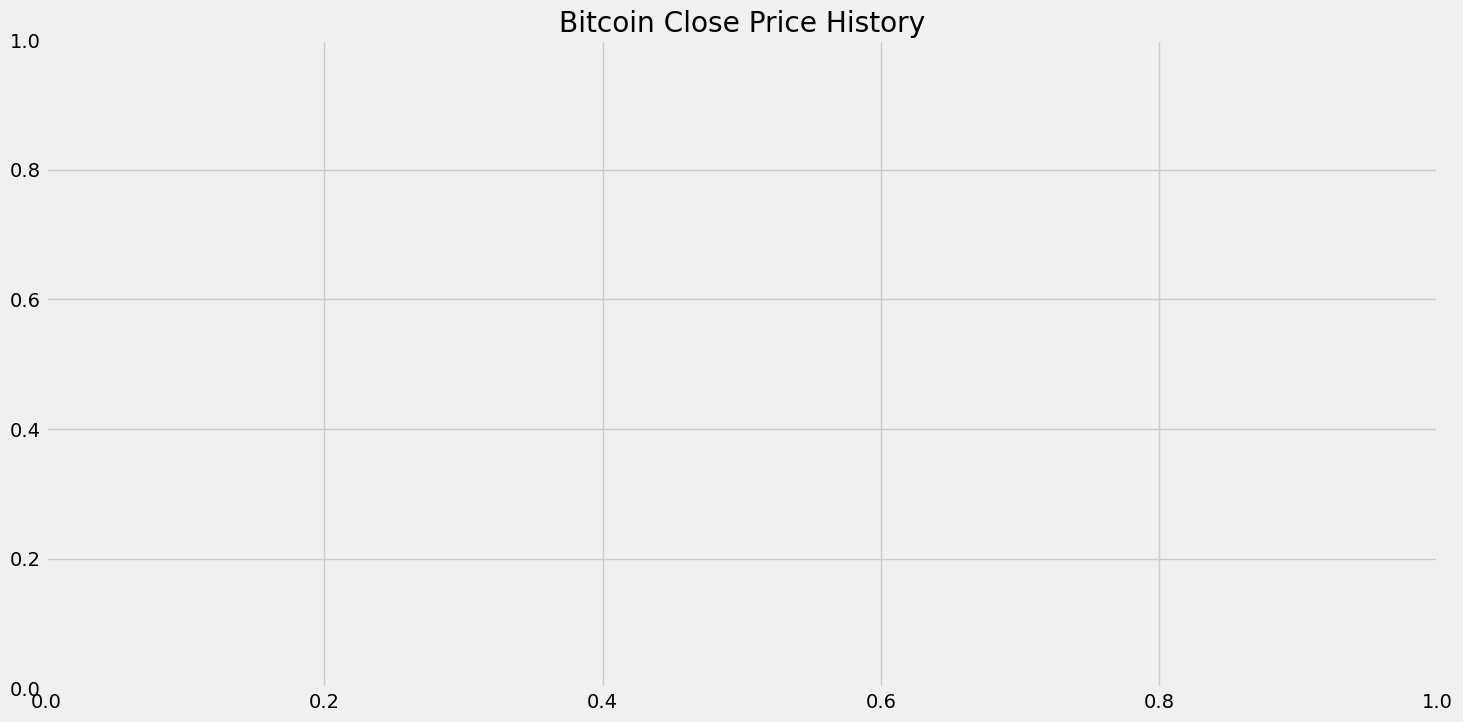

In [8]:
plt.figure(figsize=(16,8))
plt.title('Bitcoin Close Price History')
plt.plot(bitcoin_data_df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

In [ ]:
# Create a features function
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(bitcoin_data_df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [ ]:
# Define the window size
window_size = 30

# Set the index of the feature and target columns
feature_column = 1
target_column = 1

# Create the features (X) and target (y) data using the window_data() function.
X, y = window_data(bitcoin_data_df, window_size, feature_column, target_column)

# Print a few sample values from X and y
print (f"X sample values:\n{X[:3]} \n")
print (f"y sample values:\n{y[:3]}")

In [ ]:
# Splitting the data into training and testing sets
split = int(0.7 * len(X))

X_train = X[: split]
X_test = X[split:]

y_train = y[: split]
y_test = y[split:]

In [ ]:
X_train.shape

In [ ]:
# Create a MinMaxScaler object and fit 
scaler = MinMaxScaler()
scaler.fit(X)

# Scale the features training and testing sets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Fit MinMaxScaler object with the target data Y
scaler.fit(y)

# Scale target training and testing sets
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

# Reshape the features data
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Print some sample data after reshaping the datasets
print (f"X_train sample values:\n{X_train[:3]} \n")
print (f"X_test sample values:\n{X_test[:3]}")

In [ ]:
# Build the LSTM model.
model = Sequential()

# Initial model setup
number_units = 30
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

# Could try adding Dense layers here (model.add(Dense(30))

# Output layer
model.add(Dense(1))

In [ ]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

# Show the model summary
model.summary()

In [ ]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=90, verbose=1)

In [ ]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

In [ ]:
# Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [ ]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Create a DataFrame of Real and Predicted values
bitcoin_df = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = bitcoin_data_df.index[-len(real_prices): ]) 

# Show the DataFrame's head
bitcoin_df.head()

In [ ]:
# Plot the real vs predicted prices as a line chart
bitcoin_df.plot(title="Actual Vs. Predicted Bitcoin Prices")